# Importación de librerías

A continuación se importan todas las librerías necesarias para cargar las imágenes y construir el modelo de convolución.


In [ ]:
# Instalación de Kaggle
!pip install -q kaggle

In [ ]:
# Importar librerías

import PIL
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

%matplotlib inline

# Configuración de Kaggle

Se optó por cargar las imágenes utilizando el API de Kaggle por sencillez y eficiencia. La base de datos elegida para entrenar al modelo de convolución contiene imágenes sobre 4 tipos de muestras de sangre. Se eligió esta base de datos ya que modelos de clasificación como el presentado en esta actividad tiene importantes aplicaciones en el sector médico para detectar enfermedades en los pacientes.

En total, este dataset contiene 12,500 imágenes de muestras de sangre con su respectiva etiqueta indicando el tipo de célula detectada. Los tipos de células detectadas se enlistan a continuación:
- Eosinófilos
- Linfocitos
- Monocitos
- Neutrófilos

In [ ]:
# Subir llave de Kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elisasnchezbahnsen","key":"f97ef8f184dda833e6876cdb2106e7d2"}'}

In [ ]:
# Configuración de la librería de Kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

!chmod 600 ~/.kaggle/kaggle.json # Cambio en los permisos de lectura y escritura

!kaggle datasets list

ref                                                           title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset            Customer Shopping Trends Dataset                146KB  2023-10-05 06:45:37          23715        485  1.0              
alexq1111/imdb-top-rated-english-movies                       IMDb Top Rated English Movies                     4KB  2023-11-10 12:33:08            541         21  1.0              
samyakb/student-stress-factors                                Student stress factors                           887B  2023-11-02 12:42:11           3287         66  0.9411765        
joebeachcapital/30000-spotify-songs                           30000 Spotify Songs         

In [ ]:
# Se descarga la base de datos
!kaggle datasets download -d paultimothymooney/blood-cells

 90% 97.0M/108M [00:01<00:00, 74.7MB/s]
100% 108M/108M [00:01<00:00, 60.0MB/s] 


In [ ]:
# Se descomprime la carpeta con la imagenes
!unzip blood-cells.zip -d "/content/kaggledb" # esto se verá en la carpeta de content > kaggledb

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: /content/kaggledb/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: /c

# Preparación de los datos
Una vez cargadas las imágenes al entorno de ejecución, estas se mezclan de forma aleatoria en batches de 128 imágenes de cada uno. En la siguiente celda se aprecia el tamaño del set de entrenamiento validación y prueba.

In [ ]:
# Se crean los batches de entrenamiento,validación y test con las cuatro clases de forma aleatoria

%cd "/content/kaggledb/dataset2-master/dataset2-master/images/"

train_dataset = image_dataset_from_directory(
    pathlib.Path("TRAIN"),
    image_size=(240, 320),
    batch_size=128,
    shuffle=True,
    crop_to_aspect_ratio= True)
validation_dataset = image_dataset_from_directory(
    pathlib.Path("TEST"),
    image_size=(240, 320),
    batch_size=128,
    shuffle=True,
    crop_to_aspect_ratio= True)
test_dataset = image_dataset_from_directory(
    pathlib.Path("TEST_SIMPLE"),
    image_size=(240, 320),
    batch_size=128,
    shuffle=True,
    crop_to_aspect_ratio= True)

/content/kaggledb/dataset2-master/dataset2-master/images
Found 9957 files belonging to 4 classes.
Found 2487 files belonging to 4 classes.
Found 71 files belonging to 4 classes.


De igual manera y como forma de ejemplo, se imprimen las dimensiones de las imágenes dentro del primer batch, siendo este de 240x320px y 3 capas (RGB).

In [ ]:
# Se imprime el tamaño de las imágenes dentro de los batches
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (128, 240, 320, 3)
labels batch shape: (128,)


El siguiente también es un ejemplo de las etiquetas que acompañan a cada uno de los batches. En este se pueden observar las verdaderas etiquetas de cada una de las 128 imágenes dentro del batch actual.

In [ ]:
print(labels_batch)

tf.Tensor(
[3 2 2 0 1 2 2 0 2 0 3 2 2 0 0 0 3 1 1 2 3 3 2 2 0 2 2 2 0 2 2 0 3 1 2 3 2
 0 1 3 1 2 2 3 1 0 0 0 0 1 1 3 2 0 0 1 3 3 1 3 3 0 0 2 2 0 2 2 3 3 1 3 0 3
 1 0 0 2 3 2 2 0 2 1 1 0 2 3 2 2 0 0 2 1 1 3 2 3 2 2 2 3 0 0 1 1 2 3 3 0 0
 2 3 2 1 1 3 0 3 2 0 2 2 2 1 3 3 3], shape=(128,), dtype=int32)


# Modelo 1
Ya con una mejor comprensión de los datos y con una carga exitosa de los mismos, se comienza con la implementación de una red neuronal profunda sencilla. Esta contiene tres capas de convolución con kernel de tamaño 3x3 y función de activación ReLu. Estas capas convolutivas están intercaladas con algunas capas de Max Pooling. La red termina con dos capas densas, siendo una de ellas la capa de salida con función de activación Softmax.

Además, en la compilación se utiliza una función de pérdida "sparse_categorical_crossentropy" y un optimizador "Adam".

In [ ]:
# Se establece el tamaño inicial que necesitamos y la cantidad de categorías a clasificar
input_shape = (240, 320, 3)
num_classes = 4

# Construcción de un modelo secuencial
model = Sequential()
model.add(Rescaling(scale=1./255, input_shape=input_shape))

# Capas convolucionales iniciales
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa para "aplanar" las imágenes antes de las capas densas
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Se muestra la arquitectura completa del modelo. En total se tienen que entrenar 69,826,116 parámetros.

In [ ]:
# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 320, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 318, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 119, 159, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 78, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 76, 128)       7

In [ ]:
# Fit
history = model.fit(train_dataset, validation_data=validation_dataset, batch_size=64, epochs=20)

Epoch 1/20
78/78 [==============================] - 41s 396ms/step - loss: 2.0092 - accuracy: 0.2490 - val_loss: 1.3863 - val_accuracy: 0.2509
Epoch 2/20
78/78 [==============================] - 27s 334ms/step - loss: 1.3864 - accuracy: 0.2455 - val_loss: 1.3863 - val_accuracy: 0.2509
Epoch 3/20
78/78 [==============================] - 27s 334ms/step - loss: 1.3864 - accuracy: 0.2456 - val_loss: 1.3863 - val_accuracy: 0.2509
Epoch 4/20
78/78 [==============================] - 28s 348ms/step - loss: 1.3864 - accuracy: 0.2508 - val_loss: 1.3865 - val_accuracy: 0.2525
Epoch 5/20
78/78 [==============================] - 27s 336ms/step - loss: 1.3866 - accuracy: 0.2497 - val_loss: 1.3863 - val_accuracy: 0.2529
Epoch 6/20
78/78 [==============================] - 27s 333ms/step - loss: 1.3858 - accuracy: 0.2524 - val_loss: 1.3893 - val_accuracy: 0.2453
Epoch 7/20
78/78 [==============================] - 27s 338ms/step - loss: 1.3850 - accuracy: 0.2605 - val_loss: 1.3889 - val_accuracy: 0.2421

In [ ]:
# Convertir resultados a df
df = pd.DataFrame(history.history)
df

,loss,accuracy,val_loss,val_accuracy
0,2.009225,0.248971,1.386298,0.250905
1,1.386379,0.245455,1.386290,0.250905
2,1.386406,0.245556,1.386292,0.250905
3,1.386369,0.250778,1.386505,0.252513
4,1.386636,0.249674,1.386330,0.252915
5,1.385826,0.252385,1.389298,0.245275
6,1.385032,0.260520,1.388888,0.242059
7,1.383495,0.263634,1.388732,0.240048
8,1.381863,0.270061,1.387994,0.258142
9,1.378851,0.275886,1.387524,0.246482


<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

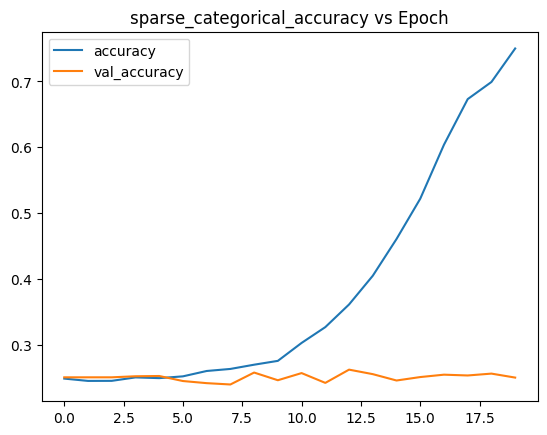

In [ ]:
# Gráfica de accuracy
df.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

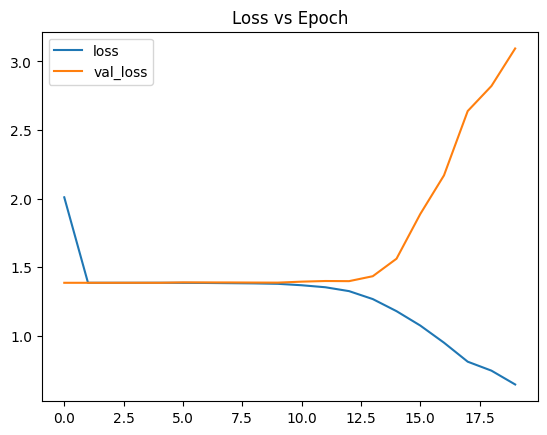

In [ ]:
# Gráfica de pérdida
df.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

Los resultados del entrenamiento de este modelo demuestran un muy mal comportamiento y capacidad de aprender de las imágenes brindadas. Principalmente la gráfica del accuracy muestran un sobre aprendizaje dado que mientras el accuracy de los datos de prueban continuan aumentando, el del set de validación se mantiene constante en 0.25 desde aproximádamente la época 10.

# Modelo 2 (mejorado)

In [ ]:
def lr_schedule(epoch):
    return 0.001 * 0.9 ** epoch

Para mejorar los resultados del modelo anterior, se opta por agregarle técnicas de regularizacion como las capas de dropout con tasa del 0.5 en las últimas capas (FCL). Adicionalmente se modificó la cantidad de neuronas en cada capa convolucional al igual que se agregó una nueva FCL al final.

In [ ]:
# Se establece el tamaño inicial que necesitamos y la cantidad de categorías a clasificar
input_shape = (240, 320, 3)
num_classes = 4

# Construcción de un modelo secuencial
model2 = Sequential()
model2.add(Rescaling(scale=1./255, input_shape=input_shape))
#model2.add(tf.keras.layers.experimental.preprocessing.Resizing(100, 100, interpolation='bilinear'))

# Capas convolucionales iniciales
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Capa para "aplanar" las imágenes antes de las capas densas
model2.add(Flatten())

# Fully connected layers
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Como se esperaba, dada la agregada complejidad del modelo, ahora se tiene una mayor cantidad de parámetros a entrenar: 139,964,292

In [ ]:
# Resumen del modelo
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 240, 320, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 238, 318, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 119, 159, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 117, 157, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 58, 78, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 76, 256)      

In [ ]:
# Fit
#lr_scheduler = LearningRateScheduler(lr_schedule)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history2 = model2.fit(train_dataset, validation_data=validation_dataset, batch_size=128, epochs=20)

Epoch 1/20
 1/78 [..............................] - ETA: 55:27 - loss: 1.3999 - accuracy: 0.2734

In [ ]:
# Convertir resultados a df
df2 = pd.DataFrame(history2.history)
df2

,loss,accuracy,val_loss,val_accuracy
0,1.474498,0.244752,1.386230,0.253317
1,1.385720,0.258612,1.386560,0.250905
2,1.383285,0.272673,1.390826,0.248090
3,1.378958,0.286331,1.395824,0.246482
4,1.371668,0.301999,1.397066,0.262163
5,1.343331,0.338254,1.343583,0.353840
6,1.124262,0.490107,1.117245,0.480499
7,0.951647,0.582103,1.063035,0.515481
8,0.830270,0.648388,1.019424,0.544029
9,0.738987,0.695591,0.976792,0.548050


<Axes: title={'center': 'sparse_categorical_accuracy vs Epoch'}>

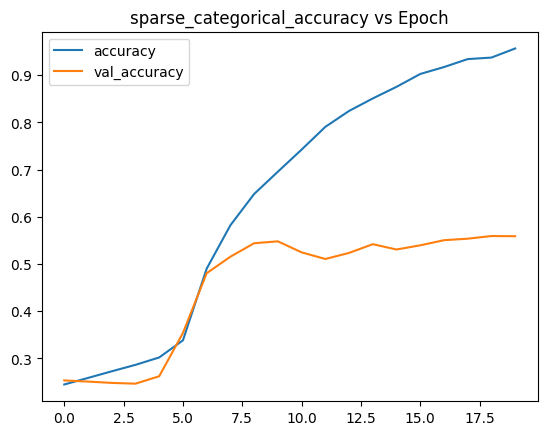

In [ ]:
# Gráfica de accuracy
df2.plot(y=["accuracy", "val_accuracy"], title="sparse_categorical_accuracy vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

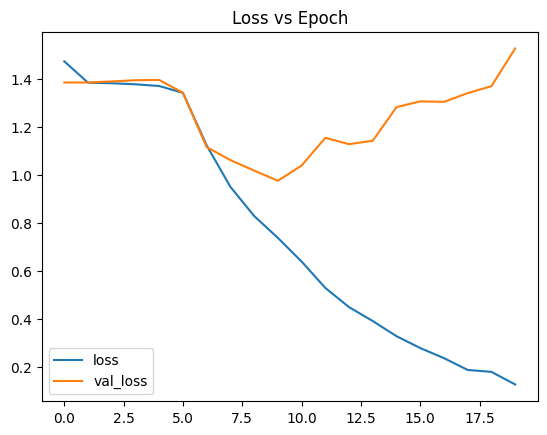

In [ ]:
# Gráfica de pérdida
df2.plot(y=["loss", "val_loss"], title="Loss vs Epoch")

Aunque se sigue percibiendo un gran sobre aprendizaje, también se pudieron apreciar algunas mejoras con este segundo modelo. Primero que nada, el accuracy del set de validación aumentó a 0.55 aproximádamente y el de prueba a 0.9. El ajuste que se tiene en mente para siguientes generaciones debe aumentar el accuracy de validación.